- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


#0.Setting

In [85]:
import torch
from torch import nn, optim
from sklearn.datasets import load_digits 
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

pytorch gpu 사용

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

#1.Data set : digits

In [86]:
data = load_digits(as_frame= True)
df = data.data
target = data.target

In [90]:
df.min()

pixel_0_0    0.0
pixel_0_1    0.0
pixel_0_2    0.0
pixel_0_3    0.0
pixel_0_4    0.0
            ... 
pixel_7_3    0.0
pixel_7_4    0.0
pixel_7_5    0.0
pixel_7_6    0.0
pixel_7_7    0.0
Length: 64, dtype: float64

In [91]:
df.max()

pixel_0_0     0.0
pixel_0_1     8.0
pixel_0_2    16.0
pixel_0_3    16.0
pixel_0_4    16.0
             ... 
pixel_7_3    16.0
pixel_7_4    16.0
pixel_7_5    16.0
pixel_7_6    16.0
pixel_7_7    16.0
Length: 64, dtype: float64

모두 수치형 데이터

In [88]:
target

0       0
1       1
2       2
3       3
4       4
       ..
1792    9
1793    0
1794    8
1795    9
1796    8
Name: target, Length: 1797, dtype: int64

target : digits

In [92]:
data = load_digits() # dataframe으로 받으면 tensor변환이 안됨
df = data.data
target = data.target

In [94]:
x_train, x_test, y_train, y_test  = train_test_split(df, target, test_size = 0.2
                                                     , random_state = 42, shuffle = True)
x_train = torch.FloatTensor(x_train).to(device) #gpu에 옮기기
y_train = torch.LongTensor(y_train).to(device)

x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [96]:
x_train[0] , x_train[0].shape

(tensor([ 0.,  0.,  3., 14.,  1.,  0.,  0.,  0.,  0.,  0., 12., 12.,  0.,  0.,
          0.,  0.,  0.,  3., 16.,  6.,  0.,  0.,  0.,  0.,  0.,  5., 16.,  2.,
          0.,  0.,  0.,  0.,  0.,  6., 16.,  2.,  5.,  2.,  0.,  0.,  0.,  4.,
         16.,  2., 12., 15.,  2.,  0.,  0.,  1., 14., 13.,  2., 13., 11.,  0.,
          0.,  0.,  3., 11., 16., 13.,  4.,  0.]), torch.Size([64]))

8x8 data- 이미 flatten 되어 있음

In [97]:
x_train.shape

torch.Size([1437, 64])

In [98]:
y_train[0]

tensor(6)

Dataloader 역할을 하는 class 정의

In [99]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train] #열 행렬로 바꿔준다.

  def __len__(self):
    return len(self.x_data)

  def __getitem__(self, idx): # slicing
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.FloatTensor(self.y_data[idx]).to(device)

    return x,y
##여기서 사용되는 x_train, y_train 모두 위에서 정의된 글로벌 변수

In [100]:
batch_size = 20

dataset = CustomDataset() # 이 안에 x_train, y_train 이 있다.
dataloader = DataLoader(dataset, batch_size = batch_size)

In [101]:
for x, y in dataloader:
  print(x, y)
  break

tensor([[ 0.,  0.,  3.,  ..., 13.,  4.,  0.],
        [ 0.,  0.,  9.,  ...,  3.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  6.,  0.,  0.],
        ...,
        [ 0.,  0.,  2.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  5.,  ...,  3.,  0.,  0.],
        [ 0.,  0.,  6.,  ...,  1.,  0.,  0.]]) tensor([[6.],
        [0.],
        [0.],
        [3.],
        [0.],
        [5.],
        [0.],
        [0.],
        [4.],
        [1.],
        [2.],
        [8.],
        [4.],
        [5.],
        [9.],
        [6.],
        [3.],
        [1.],
        [8.],
        [8.]])


#2. Modeling

###기본 모델

In [52]:
temp  = torch.tensor([1,-1,3])
torch.max(torch.zeros_like(temp), temp)

tensor([1, 0, 3])

In [102]:
#ReLU
class ReLU(torch.nn.ReLU): ## method overriding
  def forward(self, x):
    return torch.max(torch.zeros_like(x), x)


In [114]:
class Model(torch.nn.Module): #overriding
  def __init__(self):
    super(Model, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Linear(64, 200, bias = True),
        ReLU(),
        nn.BatchNorm1d(200) 
         # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌

    )

    self.layer2 = nn.Sequential(
        nn.Linear(200,100, bias = True),
        ReLU()
    )

    self.layer3 = nn.Sequential(
        nn.Linear(100, 50, bias = True),
        ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(50, 10, bias = True),
        nn.Softmax()
        # no softmax : 이미 loss에 포함 되어 있을 것.
    )

  def forward(self, x):
    o1 = self.layer1(x)
    o2 = self.layer2(o1)
    o3 = self.layer3(o2)
    output = self.layer4(o3)

    return output

단순 Gaussain 가중치 초기값

In [156]:
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std = 0.01) 

####Trainig

In [157]:
net1 = Model().to(device)
net1.apply(init_weights)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=50, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [160]:

lr, num_epochs = 0.01, 100

loss = nn.CrossEntropyLoss(reduction = "none").to(device)
optimizer = optim.SGD(net1.parameters(), lr = lr)


In [161]:
def train(x_train, y_train, num_epochs,net, optimizer, loss):
  losses = []
  for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_hat = net(x_train)
    l = loss(y_hat, y_train)
    l.mean().backward()

    optimizer.step()
    losses.append(l.mean().item())

    print(epoch, l.mean().item())

  return losses

losses =train(x_train, y_train, num_epochs, net1, optimizer, loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.30277419090271
1 2.302774429321289
2 2.302774429321289
3 2.30277419090271
4 2.30277419090271
5 2.30277419090271
6 2.30277419090271
7 2.30277419090271
8 2.30277419090271
9 2.30277419090271
10 2.302773952484131
11 2.302773952484131
12 2.302773952484131
13 2.302773952484131
14 2.302773952484131
15 2.302773952484131
16 2.302773952484131
17 2.3027737140655518
18 2.3027737140655518
19 2.3027737140655518
20 2.3027737140655518
21 2.3027737140655518
22 2.3027734756469727
23 2.3027734756469727
24 2.3027734756469727
25 2.3027734756469727
26 2.3027734756469727
27 2.3027732372283936
28 2.3027732372283936
29 2.3027732372283936
30 2.3027732372283936
31 2.3027729988098145
32 2.3027729988098145
33 2.3027729988098145
34 2.3027732372283936
35 2.3027729988098145
36 2.3027729988098145
37 2.3027729988098145
38 2.3027729988098145
39 2.3027729988098145
40 2.3027729988098145
41 2.3027729988098145
42 2.3027729988098145
43 2.3027729988098145
44 2.3027727603912354
45 2.3027725219726562
46 2.3027725219726562
4

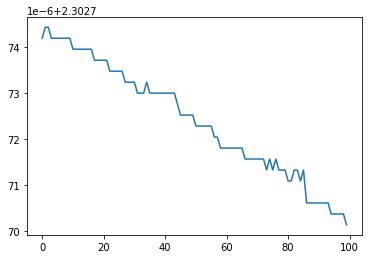

In [162]:
plt.plot(losses)
plt.show()

####Prediction

In [165]:
with torch.no_grad():
  model = net1.to('cpu')
  y_pred = net1(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}\n')
print(f'argmax를 한 후의 output은 {predicted[0]}\n')
print(f'실제 output은 {y_test[0]}\n')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.09594779 0.096877   0.09163979 0.08912709 0.10530876 0.11279582
 0.11097579 0.10197236 0.09469504 0.10066056]

argmax를 한 후의 output은 5

실제 output은 6

accuracy는 0.13055555555555556


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


###가중치 초기화 변화 : xavier 사용

In [163]:
def init_weights2(layer):
  if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

net2 = Model().to(device)
net2.apply(init_weights2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=200, out_features=100, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=50, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [152]:
num_epochs, lr = 100, 0.01
loss = nn.CrossEntropyLoss(reduction = "none").to(device)
optimizer = optim.SGD(net.parameters(), lr = lr)
losses = train(x_train, y_train,num_epochs, net, optimizer, loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.0453600883483887
1 2.044203042984009
2 2.0430498123168945
3 2.041897773742676
4 2.0407471656799316
5 2.0395984649658203
6 2.03845477104187
7 2.0373120307922363
8 2.0361719131469727
9 2.0350341796875
10 2.033900022506714
11 2.0327699184417725
12 2.0316414833068848
13 2.030512571334839
14 2.029384136199951
15 2.0282580852508545
16 2.027137279510498
17 2.0260186195373535
18 2.024902820587158
19 2.023789882659912
20 2.022678852081299
21 2.0215680599212646
22 2.020458459854126
23 2.019352436065674
24 2.0182483196258545
25 2.017145872116089
26 2.0160446166992188
27 2.0149435997009277
28 2.0138418674468994
29 2.0127382278442383
30 2.0116355419158936
31 2.0105316638946533
32 2.0094287395477295
33 2.0083227157592773
34 2.0072145462036133
35 2.0061044692993164
36 2.0049941539764404
37 2.0038840770721436
38 2.0027732849121094
39 2.00166392326355
40 2.0005528926849365
41 1.9994406700134277
42 1.9983278512954712
43 1.9972176551818848
44 1.996106505393982
45 1.994994878768921
46 1.99387860298156

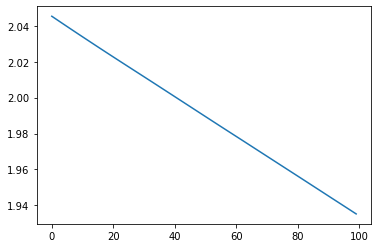

In [153]:
plt.plot(losses)
plt.show()

####Prediction

In [166]:
with torch.no_grad():
  model = net2.to('cpu')
  y_pred = net2(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}\n')
print(f'argmax를 한 후의 output은 {predicted[0]}\n')
print(f'실제 output은 {y_test[0]}\n')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.14294682 0.09115335 0.06205816 0.08205129 0.09780052 0.08701859
 0.08292494 0.15246923 0.06442708 0.13714996]

argmax를 한 후의 output은 7

실제 output은 6

accuracy는 0.03333333333333333


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


###Optimizer 변경

In [167]:
net3 = Model().to(device)
net3.apply(init_weights2) # 다시 초기화

num_epochs, lr = 100, 0.01
loss = nn.CrossEntropyLoss(reduction = "none").to(device)
optimizer = optim.Adam(net3.parameters(), lr = lr)
losses = train(x_train, y_train,num_epochs, net3, optimizer, loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.3010904788970947
1 2.0222017765045166
2 1.7829445600509644
3 1.6473489999771118
4 1.5935230255126953
5 1.5466762781143188
6 1.528504490852356
7 1.5116151571273804
8 1.498723030090332
9 1.4899003505706787
10 1.4827312231063843
11 1.477992057800293
12 1.4756393432617188
13 1.4741158485412598
14 1.473376750946045
15 1.4718759059906006
16 1.4713265895843506
17 1.4706476926803589
18 1.4699124097824097
19 1.4696179628372192
20 1.469557523727417
21 1.4695532321929932
22 1.469577431678772
23 1.4695444107055664
24 1.4695159196853638
25 1.469487190246582
26 1.4694615602493286
27 1.4694137573242188
28 1.46916925907135
29 1.468933343887329
30 1.4688955545425415
31 1.468756079673767
32 1.468748688697815
33 1.4687484502792358
34 1.4687477350234985
35 1.4687433242797852
36 1.468733310699463
37 1.46872079372406
38 1.4687180519104004
39 1.4687243700027466
40 1.4687267541885376
41 1.4687261581420898
42 1.4687235355377197
43 1.4687199592590332
44 1.4687148332595825
45 1.4687079191207886
46 1.46870636

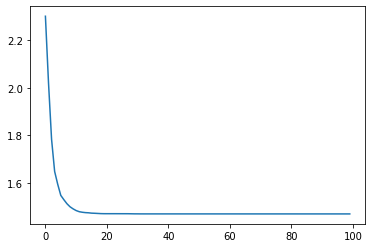

In [168]:
plt.plot(losses)
plt.show()

In [169]:
with torch.no_grad():
  model = net3.to('cpu')
  y_pred = net3(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}\n')
print(f'argmax를 한 후의 output은 {predicted[0]}\n')
print(f'실제 output은 {y_test[0]}\n')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.6286398e-19 7.4972861e-16 4.1747204e-21 2.0072627e-18 5.3884431e-17
 3.1605552e-18 1.0000000e+00 3.3335183e-24 1.4818355e-12 1.5098295e-19]

argmax를 한 후의 output은 6

실제 output은 6

accuracy는 0.9666666666666667


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### Weight Decay

In [185]:
net4 = Model().to(device)
net4.apply(init_weights2) # 다시 초기화

num_epochs, lr = 100, 0.01
loss = nn.CrossEntropyLoss(reduction = "none").to(device)
optimizer = optim.Adam(net4.parameters(), weight_decay = 2, lr= lr)
losses = train(x_train, y_train,num_epochs, net4, optimizer, loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.3128645420074463
1 2.308993101119995
2 2.307123899459839
3 2.3057665824890137
4 2.304553270339966
5 2.303725004196167
6 2.302919626235962
7 2.3023834228515625
8 2.3019144535064697
9 2.3017382621765137
10 2.3018383979797363
11 2.3020541667938232
12 2.3022422790527344
13 2.3023486137390137
14 2.30240797996521
15 2.3024723529815674
16 2.3025009632110596
17 2.302520275115967
18 2.3025007247924805
19 2.3024744987487793
20 2.302461624145508
21 2.3024635314941406
22 2.302480459213257
23 2.302507162094116
24 2.3025336265563965
25 2.302551507949829
26 2.302563428878784
27 2.3025753498077393
28 2.3025879859924316
29 2.302596092224121
30 2.3026022911071777
31 2.3026037216186523
32 2.3026022911071777
33 2.302600145339966
34 2.3025975227355957
35 2.302593946456909
36 2.3025898933410645
37 2.3025856018066406
38 2.3025827407836914
39 2.3025810718536377
40 2.302579879760742
41 2.302579879760742
42 2.3025810718536377
43 2.3025827407836914
44 2.302583932876587
45 2.3025848865509033
46 2.302584409713

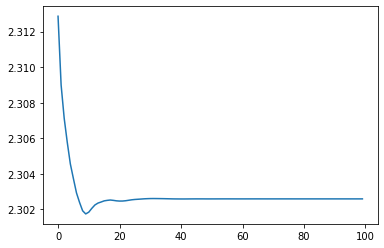

In [186]:
plt.plot(losses)
plt.show()

오히려 loss가 올라간다.

In [187]:
with torch.no_grad():
  model = net4.to('cpu')
  y_pred = net4(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}\n')
print(f'argmax를 한 후의 output은 {predicted[0]}\n')
print(f'실제 output은 {y_test[0]}\n')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.10000432 0.10003275 0.09999727 0.10002273 0.09997292 0.09997483
 0.10001002 0.10000101 0.09999745 0.09998663]

argmax를 한 후의 output은 1

실제 output은 6

accuracy는 0.07777777777777778


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


###dropout

In [189]:
dropout2 = 0.2
dropout3 = 0.5

In [194]:
from torch.nn.modules import dropout
class Model2(torch.nn.Module): #overriding
  def __init__(self):
    super(Model, self).__init__()

    self.layer1 = nn.Sequential(
        nn.Linear(64, 200, bias = True),
        ReLU(),
        nn.BatchNorm1d(200) 
         # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌

    )

    self.layer2 = nn.Sequential(
        nn.Linear(200,100, bias = True),
        ReLU(),
        nn.Dropout(dropout2)
    )

    self.layer3 = nn.Sequential(
        nn.Linear(100, 50, bias = True),
        ReLU(),
        nn.Dropout(dropout3)
    )
    self.layer4 = nn.Sequential(
        nn.Linear(50, 10, bias = True),
        nn.Softmax()
        # no softmax : 이미 loss에 포함 되어 있을 것.
    )

  def forward(self, x):
    o1 = self.layer1(x)
    o2 = self.layer2(o1)
    o3 = self.layer3(o2)
    output = self.layer4(o3)

    return output

In [199]:
from torch.nn.modules import dropout
net5 = nn.Sequential(nn.Flatten(), 
                     nn.Linear(64, 200, bias = True),
                     ReLU(),
                     nn.Linear(200, 100, bias = True),
                     ReLU(),
                     nn.Dropout(dropout2),
                     nn.Linear(100, 50, bias = True),
                     ReLU(),
                     nn.Dropout(dropout3),
                     nn.Linear(50, 10, bias = True),
                     nn.Softmax())


In [200]:
# net5 = Model2().to(device)
net5.apply(init_weights2) # 다시 초기화

num_epochs, lr = 100, 0.01
loss = nn.CrossEntropyLoss(reduction = "none").to(device)
optimizer = optim.Adam(net5.parameters(), weight_decay = 2, lr= lr)
losses = train(x_train, y_train,num_epochs, net5, optimizer, loss)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 2.3554251194000244
1 2.3558504581451416
2 2.323030948638916
3 2.3131186962127686
4 2.304900884628296
5 2.298044443130493
6 2.2958648204803467
7 2.2974789142608643
8 2.2982869148254395
9 2.300474166870117
10 2.3021204471588135
11 2.3025383949279785
12 2.3025970458984375
13 2.302591323852539
14 2.3025479316711426
15 2.3025574684143066
16 2.302474021911621
17 2.302503824234009
18 2.302501916885376
19 2.3025472164154053
20 2.3025617599487305
21 2.302611827850342
22 2.30255126953125
23 2.302537202835083
24 2.3025057315826416
25 2.30253005027771
26 2.302502155303955
27 2.3025197982788086
28 2.3025436401367188
29 2.3025472164154053
30 2.302560329437256
31 2.3025684356689453
32 2.3025786876678467
33 2.302582263946533
34 2.302583932876587
35 2.3025848865509033
36 2.302584171295166
37 2.302584648132324
38 2.302583932876587
39 2.3025851249694824
40 2.302584409713745
41 2.3025848865509033
42 2.302584409713745
43 2.3025834560394287
44 2.302583932876587
45 2.302583932876587
46 2.302584409713745
47

In [201]:
with torch.no_grad():
  model = net5.to('cpu')
  y_pred = net5(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}\n')
print(f'argmax를 한 후의 output은 {predicted[0]}\n')
print(f'실제 output은 {y_test[0]}\n')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.10000408 0.10003442 0.10000027 0.100019   0.09996805 0.09996992
 0.10000731 0.10001025 0.09999975 0.09998693]

argmax를 한 후의 output은 1

실제 output은 6

accuracy는 0.07777777777777778


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
